In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

### Simulate and forecast a random walk

In [2]:
np.random.seed(30)
steps = np.random.standard_normal(500)
steps[0] = 10
random_walk = np.cumsum(steps)

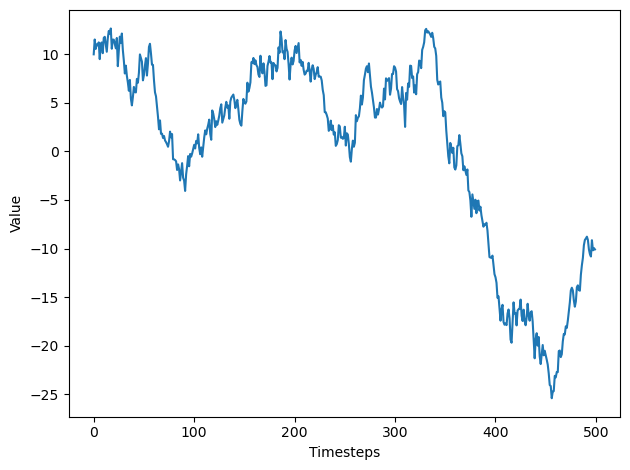

In [3]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

### Doing Adfuller test on random walk

In [4]:
Adf_result = adfuller(random_walk)

print(f'ADF statistic: {Adf_result[0]}')
print(f'P value: {Adf_result[1]}')
print(f'Critical values : {Adf_result[4]}')

ADF statistic: -1.062171670669783
P value: 0.7299193432638523
Critical values : {'1%': -3.4435494520411605, '5%': -2.8673612117611267, '10%': -2.5698704830567247}


In [5]:
diff_random_walk = np.diff(random_walk, n=1)

In [6]:
Adf_result = adfuller(diff_random_walk)

print(f'ADF statistic: {Adf_result[0]}')
print(f'P value: {Adf_result[1]}')
print(f'Critical values : {Adf_result[4]}')

ADF statistic: -24.36465831295855
P value: 0.0
Critical values : {'1%': -3.4435494520411605, '5%': -2.8673612117611267, '10%': -2.5698704830567247}


In [7]:
df = pd.DataFrame({'value' : random_walk})

train = df[:400]
test = df[400:]

* Mean

In [8]:
mean = np.mean(train.value)
test.loc[:, 'pred_mean'] = mean
test.head()

C:\Users\Pratham\AppData\Local\Temp\ipykernel_17432\3058291559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = mean


,value,pred_mean
400,-12.958769,4.811458
401,-13.533387,4.811458
402,-15.077267,4.811458
403,-14.922845,4.811458
404,-16.223519,4.811458


* Last known value

In [9]:
last_value = train.iloc[-1].value
test.loc[:, 'pred_last'] = last_value
test.head()

C:\Users\Pratham\AppData\Local\Temp\ipykernel_17432\2342727651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last'] = last_value


,value,pred_mean,pred_last
400,-12.958769,4.811458,-12.645375
401,-13.533387,4.811458,-12.645375
402,-15.077267,4.811458,-12.645375
403,-14.922845,4.811458,-12.645375
404,-16.223519,4.811458,-12.645375


* Drift

In [10]:
deltaX = 400 - 0
deltaY = last_value - 10
drift = deltaY / deltaX
x_vals = np.arange(400, 500, 1)
pred_drift = drift * x_vals + 10
test.loc[:, 'pred_drift'] = pred_drift
test.head()

C:\Users\Pratham\AppData\Local\Temp\ipykernel_17432\259017556.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_drift'] = pred_drift


,value,pred_mean,pred_last,pred_drift
400,-12.958769,4.811458,-12.645375,-12.645375
401,-13.533387,4.811458,-12.645375,-12.701988
402,-15.077267,4.811458,-12.645375,-12.758602
403,-14.922845,4.811458,-12.645375,-12.815215
404,-16.223519,4.811458,-12.645375,-12.871828


### Plotting all naive methods

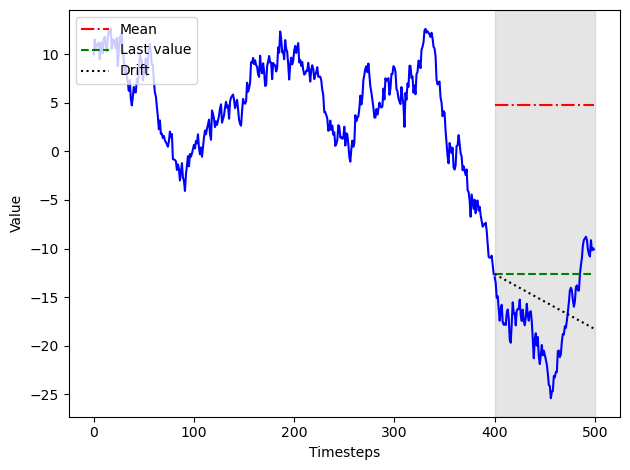

In [11]:
fig, ax = plt.subplots()

ax.plot(train['value'], 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(400, 500, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [12]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

493.5428333394411 35.317646585758965 25.659999536698628


In [13]:
# Forecast the next timestep
df_shift = df.shift(periods=1)
mse_one_step = mean_squared_error(test['value'], df_shift[400:])
mse_one_step

1.029667859568578

* forecast using one step

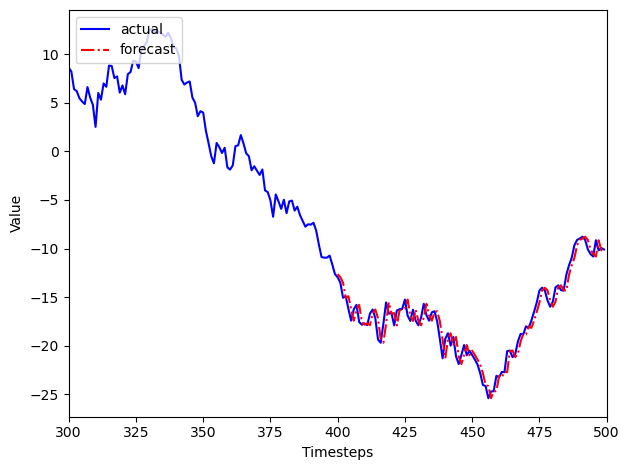

In [14]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift[400:], 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(300, 500)
plt.tight_layout()

### Testing for stationarity

* Mean over time

In [20]:
def mean_over_time(process: np.array) -> np.array:
    mean_func = []
    
    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))
    
    return mean_func

e:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\anaconda\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


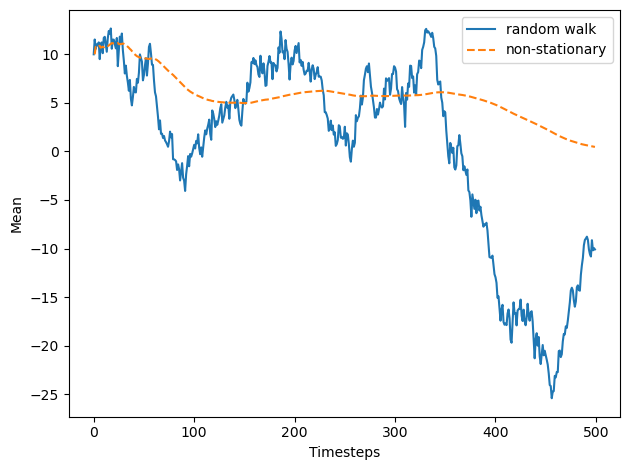

In [22]:
non_stationary_mean = mean_over_time(random_walk)

fig, ax = plt.subplots()

ax.plot(random_walk, label='random walk')
ax.plot(non_stationary_mean, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)

plt.tight_layout()

* Variance over time

In [24]:
def var_over_time(process: np.array) -> np.array:
    var_func = []
    
    for i in range(len(process)):
        var_func.append(np.var(process[:i]))
    
    return var_func

e:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
e:\anaconda\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
e:\anaconda\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


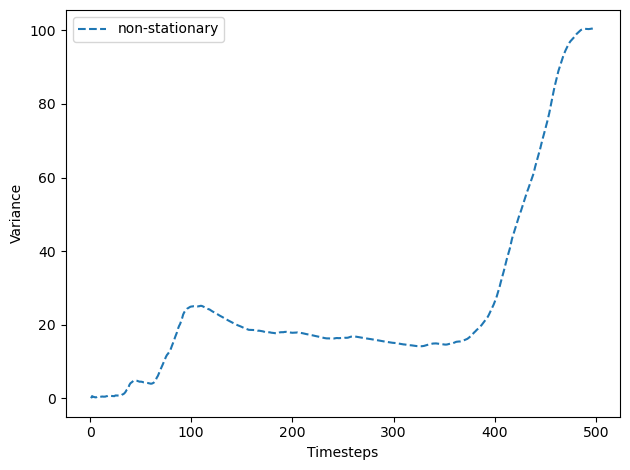

In [25]:
non_stationary_var = var_over_time(random_walk)

fig, ax = plt.subplots()

ax.plot(non_stationary_var, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')
ax.legend(loc=2)

plt.tight_layout()

* plotting acf

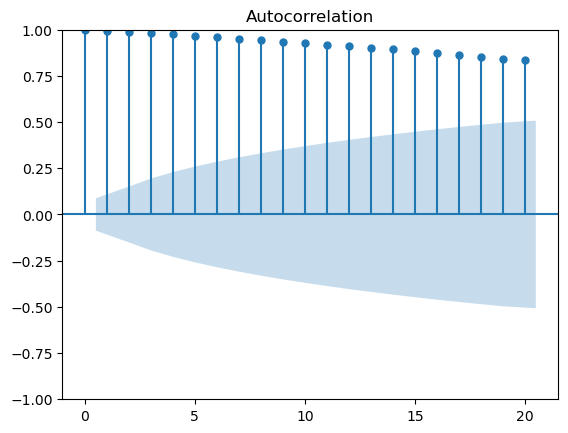

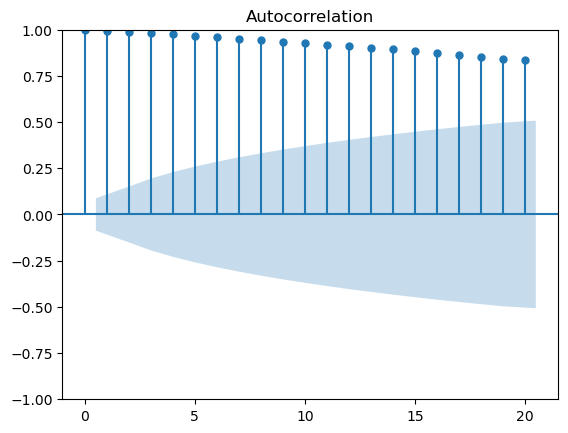

In [19]:
plot_acf(random_walk, lags=20)

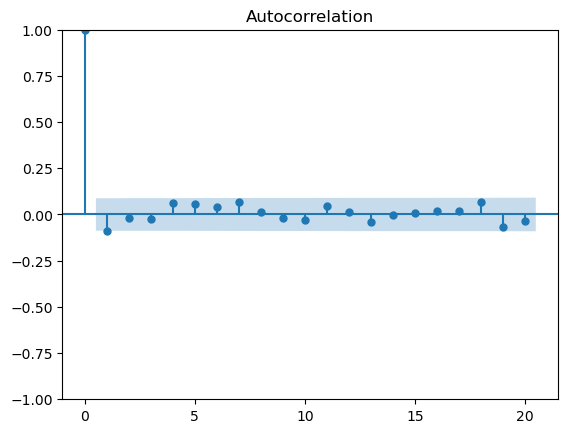

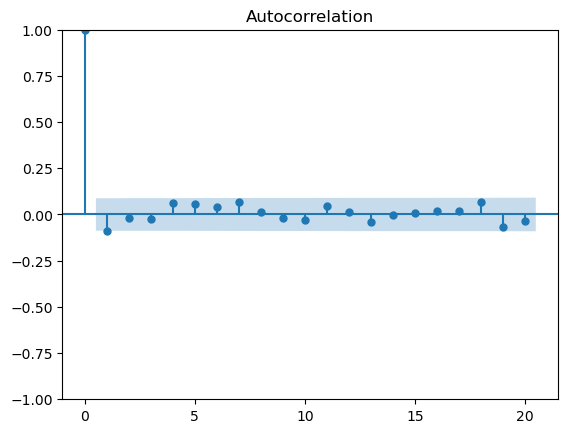

In [26]:
plot_acf(diff_random_walk, lags=20)